Part 1 - Exploratory Data Analysis

/var/folders/yt/sy7z4yq9639_05r46b0x1gmm0000gn/T/ipykernel_9239/2712658316.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  logins_resampled = logins.resample('15T').size()


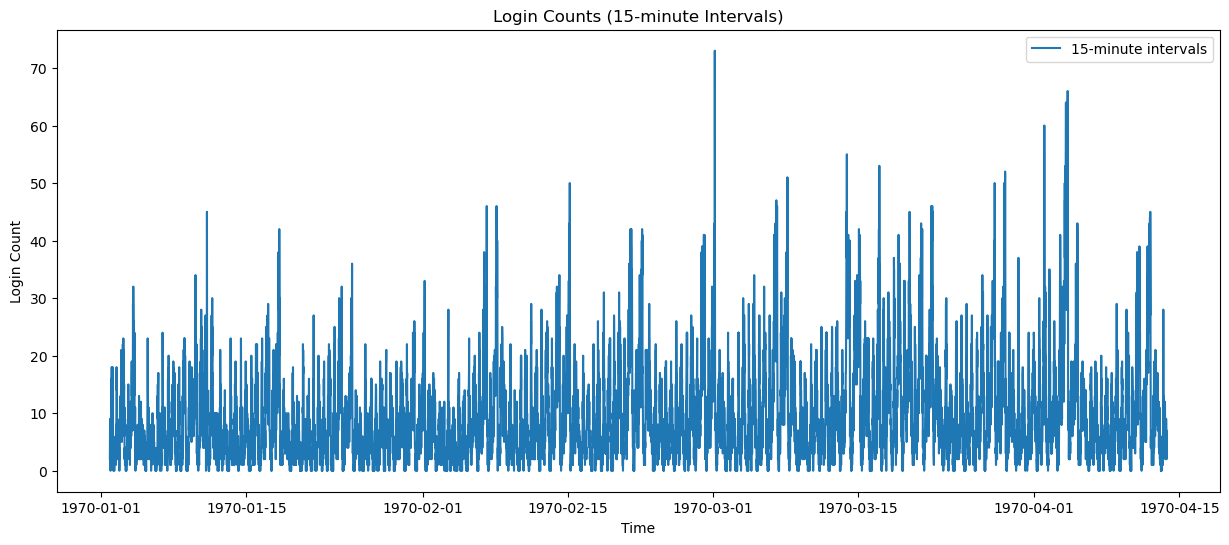

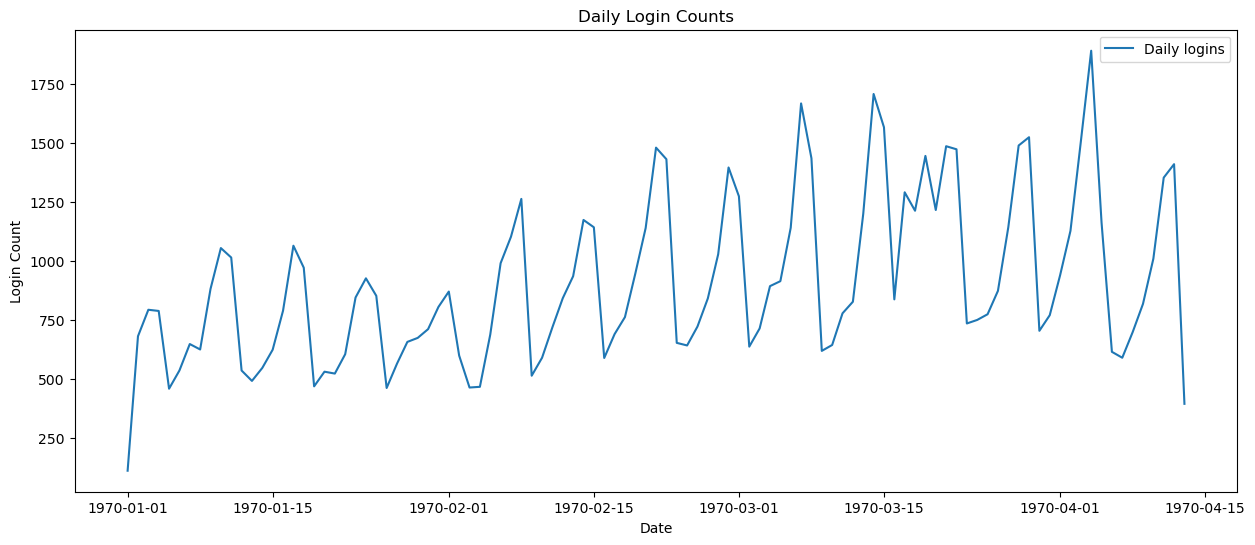

Summary of resampled login data:
count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
dtype: float64

Missing values: 0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Loading the logins.json file
logins = pd.read_json('logins.json')
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)

# Aggregating login counts based on 15-minute intervals
logins_resampled = logins.resample('15T').size()

# Visualization the aggregated time series
plt.figure(figsize=(15, 6))
plt.plot(logins_resampled, label='15-minute intervals')
plt.title('Login Counts (15-minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.legend()
plt.show()

# daily cycles analysis
logins_daily = logins_resampled.resample('D').sum()
plt.figure(figsize=(15, 6))
plt.plot(logins_daily, label='Daily logins')
plt.title('Daily Login Counts')
plt.xlabel('Date')
plt.ylabel('Login Count')
plt.legend()
plt.show()

# potential data quality issues
print("Summary of resampled login data:")
print(logins_resampled.describe())
print("\nMissing values:", logins_resampled.isnull().sum())


Part 2: Experiment and Metrics Design

Key Measure of Success:
Percentage increase in drivers starting in Gotham and ending Metropolis, or drivers that start in Metropolis and end in Gotham based on two way reimbursed tolls.

Experiment Design:
Use an A/B testing approach:

Control Group: Drivers that only make trips in Gotham, and Drivers that only make trips in Metropolis by seeing wich drivers do not pay the toll.

Treatment Group: Drivers that pay the two ways.

Track metrics like trip frequency, driver availability, and revenue to see if drivers are being cross available in both cities.

Statistical Tests: T-test for significance.

Interpretation and Recommendations:

Use statistical test results to decide the success of toll reimbursement.
Identify potential challenges (e.g., Drivers not finding trips at different active hours between both cities).

Part 3

/var/folders/yt/sy7z4yq9639_05r46b0x1gmm0000gn/T/ipykernel_11704/43415782.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['avg_rating_by_driver'].fillna(data['avg_rating_by_driver'].mean(), inplace=True)
/var/folders/yt/sy7z4yq9639_05r46b0x1gmm0000gn/T/ipykernel_11704/43415782.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object

Logistic Regression Performance (No Leakage):
[[3822 5557]
 [1673 3948]]
              precision    recall  f1-score   support

       False       0.70      0.41      0.51      9379
        True       0.42      0.70      0.52      5621

    accuracy                           0.52     15000
   macro avg       0.56      0.55      0.52     15000
weighted avg       0.59      0.52      0.52     15000

AUC-ROC: 0.55
Random Forest Performance (No Leakage):
[[7313 2066]
 [2421 3200]]
              precision    recall  f1-score   support

       False       0.75      0.78      0.77      9379
        True       0.61      0.57      0.59      5621

    accuracy                           0.70     15000
   macro avg       0.68      0.67      0.68     15000
weighted avg       0.70      0.70      0.70     15000

AUC-ROC: 0.74


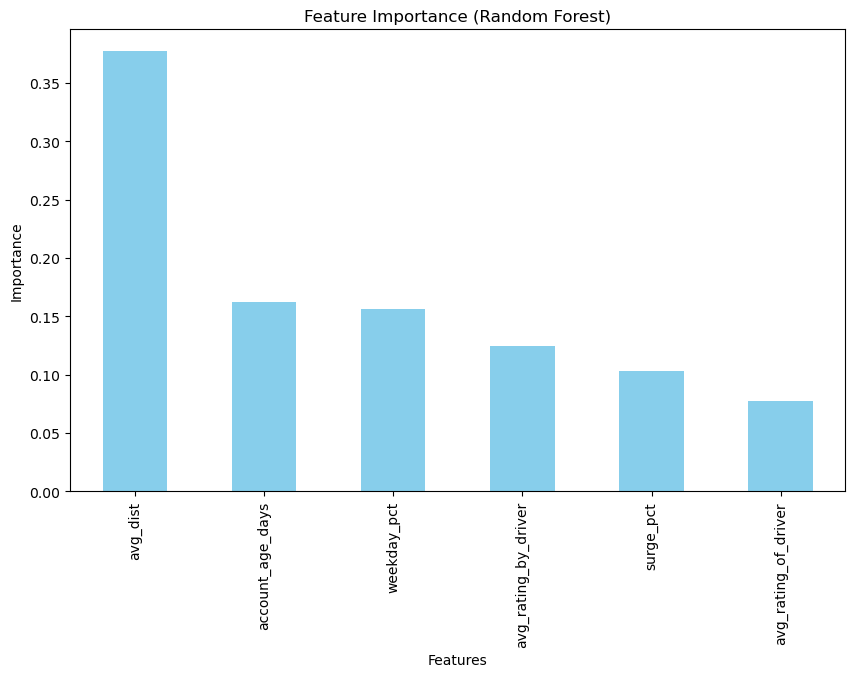

Logistic Regression CV AUC-ROC (No Leakage): 0.55
Random Forest CV AUC-ROC (No Leakage): 0.74


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight


data = pd.read_json('ultimate_data_challenge.json')

# Feature Engineering
# datetime format
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])


# The target variable: Active in the 6th month
sixth_month_end = data['signup_date'] + pd.DateOffset(months=6)

# The maximum date in the dataset
max_date = data['last_trip_date'].max()

# Making the target variable based on 30 days before the maximum date
data['active_6th_month'] = (data['last_trip_date'] >= (max_date - pd.Timedelta(days=30)))

# Account age in days (remains)
data['account_age_days'] = (data['signup_date'] - data['signup_date'].min()).dt.days

# Filling missing values for ratings
data['avg_rating_by_driver'].fillna(data['avg_rating_by_driver'].mean(), inplace=True)
data['avg_rating_of_driver'].fillna(data['avg_rating_of_driver'].mean(), inplace=True)


features = ['avg_rating_by_driver', 'avg_rating_of_driver', 
            'avg_dist', 'surge_pct', 'weekday_pct', 'account_age_days']  
X = data[features]
y = data['active_6th_month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

logistic_model = LogisticRegression(random_state=42, class_weight=class_weight_dict, max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

# Logistic Regression metrics
print("Logistic Regression Performance (No Leakage):")
print(confusion_matrix(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))
print(f"AUC-ROC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1]):.2f}")

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Random Forest metrics
print("Random Forest Performance (No Leakage):")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(f"AUC-ROC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.2f}")

# Feature Importance for Random Forest
feature_importance = pd.Series(rf_model.feature_importances_, index=features)
feature_importance.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Cross-Validation
cv_scores_logistic = cross_val_score(logistic_model, X, y, cv=5, scoring='roc_auc')
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')

print(f"Logistic Regression CV AUC-ROC (No Leakage): {np.mean(cv_scores_logistic):.2f}")
print(f"Random Forest CV AUC-ROC (No Leakage): {np.mean(cv_scores_rf):.2f}")


The Random forest performs much better than the Logistic regression. It appears that the best features for predicting retention of customers are the average distance traveled by the customer, the length of the account age, and a higher percentage of the user's trips occurring during the weekday. It is suggested that Ultimate Co. focuses on their customers who take a large percentage of their trips during the weekdays, have an old account age, and on average go further distances. Tending to greater customer service, and perhaps incentivizing great drivers to work during the weekdays, and also incentivizing drivers with more pay for longer distances will help assure higher customer satisfaction and higher customer retention.